# Interannual variability IMERG

## Calling the packages

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

## Calling dask

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="128GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.120.141/130143/1' processes=1 threads=256, memory=119.21 GiB>

## Setting functions

In [3]:
def spatial_mean_model(file,var,times):
    ## Compute the weighted sptail mean 
    ### file :  file of the data set.
    ### var: variable
    ### times : [times_begin times_end] initial and last time of the analysis
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
        time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_total = area.sel(lat=slice(-30,30)).sum()
    
    ## Spatial mean
    pr=((dset1[var]*area).sum(dim=('lon','lat'))/area_total)
    return pr.compute()

In [4]:
def cal_area_tropics(file):
    ## Calculate the area in the tropics 
    ### file :  file of the data set.
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
                lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_tropics =  area.sel(lat=slice(-30,30)).sum()
    return area_tropics

#### Compute terms in Equation 4

$\alpha_{0}^{\tau}(t)$ : area fraction of precipitation rates less than $\tau$

$\alpha_{\tau}^{\infty}(t)$ : area fraction of precipitation rates greater than $\tau$

$I_{0}^{\tau}(t)$ : mean intenity of precipitation rates less than $\tau$

$I_{\tau}^{\infty}(t)$ : mean intensity of precipitation rates greater than $\tau$

In [5]:
def intensity_afraction(file,var,times,tau,factor=(1/3600/24)):
    ## Calculate the terms in the tropics
    
    ### file :  file of the data set.
    ### var: variable
    ### times : [times_begin times_end] initial and last time of the analysis
    ### tau : list for the different values of tau (see Equation 4)
    ### factor : 1 when is IMERG; 1/3600/24 when ICON data is used
    
    ## Radius of the Earth
    earthr = 6.371e6
    
    ## Extract data set
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
                time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    
    ## Calculate the area of every grid cell in the dataset or xarray
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    
    ## Total area in the tropics
    area_tropics =  area.sel(lat=slice(-30,30)).sum()
    
    area_region = [area.sel(lat=slice(-30,30)).where(dset1[var]<threshold).sum(dim=('lon','lat')) \
                       for threshold in tau]
    area_region_1 = xr.concat(area_region,pd.Index(tau,name="tau")).compute()
        
    
    pr_region = [(dset1[var].where(dset1[var]<threshold*factor)*area).sum(dim=('lon','lat')).compute()/\
                   area_region_1.sel(tau=threshold) for threshold in tau]
    pr_region_1 = xr.concat(pr_region,pd.Index(tau,name="tau"))
    
    pr_region_n = [(dset1[var].where(dset1[var]>=threshold*factor)*area).sum(dim=('lon','lat')).compute()/\
                   (area_tropics - area_region_1.sel(tau=threshold)) for threshold in tau]
    pr_region_2 = xr.concat(pr_region_n,pd.Index(tau,name="tau"))
    
    
    return area_region_1/area_tropics, 1-(area_region_1/area_tropics), pr_region_1, pr_region_2

In [6]:
#Define a global pattern to find the files
glob_pattern_imerg = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_imerg}*.nc')])[:]

## Computing

### Generate files

In [7]:
#Define a global pattern to find the files
glob_pattern_imerg = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_imerg}*.nc')])[:]

In [8]:
### Calculate the time series of mean precipitation 

In [9]:
%%time
trop_imerg = spatial_mean_model(file_imerg,'calibrated_precipitation',['2009-01-01','2020-12-31'])

CPU times: user 40.5 s, sys: 1min 6s, total: 1min 46s
Wall time: 57.8 s


### Components in Equation 4 

**Tau $\tau$**

In [10]:
limits = [0.1,1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200]

### Calculation

region1 =>  $\alpha_{0}^{\tau}(t)$, $I_{0}^{\tau}(t)$; 

region2 => $\alpha_{\tau}^{\infty}(t)$ , $I_{\tau}^{\infty}(t)$

#### IMERG

In [11]:
%%time
area_1, area2, intensity_1, intensity_2 = intensity_afraction(
    file_imerg,'calibrated_precipitation',['2009-01-01','2020-12-31'],limits,factor=1)

CPU times: user 59min 18s, sys: 3h 25min 14s, total: 4h 24min 32s
Wall time: 35min 49s


In [12]:
##Mean

In [13]:
mean_area1 = area_1.resample(time='YS').mean().reindex_like(area_1.time).ffill('time')

In [14]:
mean_area2 = area2.resample(time='YS').mean().reindex_like(area2.time).ffill('time')

In [15]:
mean_intensity1 = intensity_1.resample(time='YS').mean().reindex_like(intensity_1.time).ffill('time')

In [16]:
mean_intensity2 = intensity_2.resample(time='YS').mean().reindex_like(intensity_2.time).ffill('time')

In [17]:
##Anomalies

In [18]:
anom_area1 = area_1 - mean_area1

In [19]:
anom_area2 = area2 - mean_area2

In [20]:
anom_intensity1 = intensity_1 - mean_intensity1

In [21]:
anom_intensity2 = intensity_2 - mean_intensity2

In [22]:
##dif intensity

In [23]:
dif_intensity = intensity_2 - intensity_1

In [24]:
mean_dif_intensity = dif_intensity.resample(time='YS').mean().reindex_like(dif_intensity.time).ffill('time')

In [25]:
anom_dif_intensity = dif_intensity - mean_dif_intensity

In [26]:
##tensors

In [27]:
mean_anom_dif_intensity_area2 = (anom_dif_intensity*anom_area2).resample(
    time='YS').mean().reindex_like(anom_dif_intensity.time).ffill('time')

In [28]:
anom_dif_intensity_area2 = anom_dif_intensity*anom_area2

In [29]:
##precipitation anomalies

In [30]:
trop_imerg_mean = trop_imerg.resample(time='YS').mean().reindex_like(trop_imerg.time).ffill('time')

In [31]:
trop_imerg_anom = trop_imerg - trop_imerg.resample(time='YS').mean().reindex_like(trop_imerg.time).ffill('time')

In [32]:
##correlations

In [33]:
def correlation(data_2d,data_1d,dimension):
    years = np.unique(trop_imerg_anom['time'].dt.year)
    r_values = [xr.corr(data_2d.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31')),
                       data_1d.sel(time=slice(str(year)+'-01-01',str(year)+'-12-31')),
                       dim=dimension) for year in years]
    return xr.concat(r_values,pd.Index(years,name="years"))

In [34]:
r_intensity_1 = correlation(anom_intensity1,trop_imerg_anom,dimension='time') 

In [35]:
r_diff_intensity = correlation(anom_dif_intensity ,trop_imerg_anom,dimension='time') 

In [36]:
r_tensor2 = correlation(anom_dif_intensity_area2 ,trop_imerg_anom,dimension='time') 

In [37]:
r_area2 = correlation(anom_area2 ,trop_imerg_anom,dimension='time') 

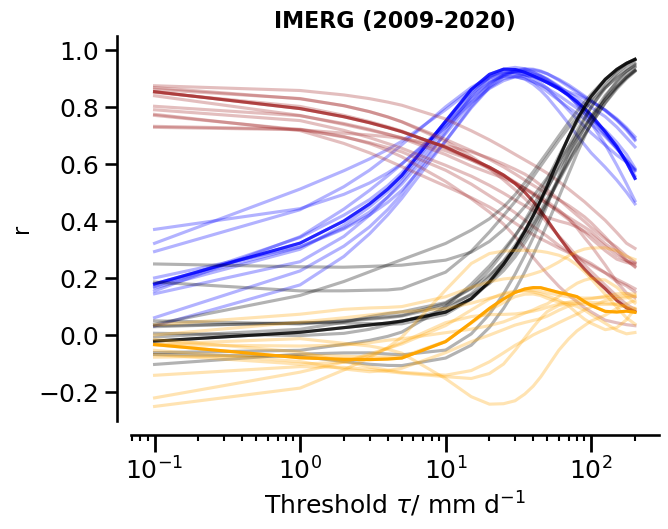

In [56]:
sns.set_context("talk")
fig = plt.figure(figsize=(15, 5),facecolor='white')
ax = fig.add_subplot(121)
plt.plot(r_area2.tau,r_area2.transpose(),color='blue',alpha=0.3);
plt.plot(r_area2.tau,r_area2.sel(years=2020),color='blue',alpha=0.8);

plt.plot(r_area2.tau,r_diff_intensity.transpose(),color='brown',alpha=0.3);
plt.plot(r_area2.tau,r_diff_intensity.sel(years=2020),color='brown',alpha=0.8);

plt.plot(r_area2.tau,r_intensity_1.transpose(),color='k',alpha=0.3);
plt.plot(r_area2.tau,r_intensity_1.sel(years=2020),color='k',alpha=0.8);

plt.plot(r_area2.tau,r_tensor2.transpose(),color='orange',alpha=0.3);
plt.plot(r_area2.tau,r_tensor2.sel(years=2020),color='orange',alpha=1);

ax.set_xscale('log');ax.set_ylim([-0.3,1.05])
ax.tick_params(labelsize=18);
ax.set_ylabel('r',fontsize=16);ax.set_xlabel(r"Threshold $\tau$/ mm d$^{-1}$",fontsize=18)
ax.tick_params(axis='x',which='minor',length=4);ax.tick_params(axis='x',which='major',length=12.5,width=2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title('IMERG (2009-2020)',fontsize=16,fontweight='bold')
sns.despine(offset=10)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/correlation_components_equation_precip_vairbaility_imerg_2009_2020.png'
    ,dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})
